In [69]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, ImageOps, Image  
import string
import random
from collections import namedtuple
%matplotlib inline

In [70]:
class FontProxy:
    FONT_NAMES = ['AndaleMono', 'Arial', 'CenturyGothic', 'FuturaBook', 'SansSerif']
    
    def __init__(self):
        self.font_dict = {}
        
    def get_font_names(self):
        return self.FONT_NAMES
        
    def generate_font(self, font_name, font_size):
        if font_name not in self.get_font_names():
            raise Exception("Invalid font name")
        font_key = (font_name, font_size)
        if font_key not in self.font_dict:
            font_path = "fonts/{0}.ttf".format(font_name)
            self.font_dict[font_key] = ImageFont.truetype(font_path, font_size)
        return self.font_dict[font_key]

In [169]:
params_list = ['pos', 'scale', 'text', 'font', 'background', 'color', 'angle', 'noise_count']
ImageParamsTuple = namedtuple('ImageParams', params_list)

class ImageParamsGenerator:        
    DEFAULT_FONT_SIZE = 35

    def __init__(self, max_color_diff=40, rotate_text=False, empty_text=False):
        self.max_color_diff = max_color_diff
        self.rotate_text = rotate_text
        self.empty_text = empty_text
        self.font_proxy = FontProxy()
        
    def generate_position_and_scale(self):
        scale = random.uniform(0.4, 1.0)        
        max_pos = int(8 - ((scale - 0.4) / 0.6) * 8)
        pos_x = random.choice(range(-max_pos, max_pos + 1))
        pos_y = random.choice(range(-max_pos, max_pos + 1))   
        return ((pos_x, pos_y), scale)
        
    def generate_text(self):
        char_list = list(string.ascii_uppercase + string.digits)
        if self.empty_text:
            char_list.append('')
        return random.choice(char_list)

    def generate_font(self, scale):
        font_name = random.choice(self.font_proxy.get_font_names())
        font_size = int(self.DEFAULT_FONT_SIZE * scale)
        return self.font_proxy.generate_font(font_name, font_size)
            
    def generate_image_text_colors(self):
        image_color = random.choice(range(0, 256 - self.max_color_diff))
        text_color = random.choice(range(image_color + self.max_color_diff, 256))
        return (image_color, text_color)
    
    def generate_rotation_angle(self):
        if self.rotate_text == False:
            return 0
        return random.choice(range(-45, 46))    
    
    def generate_noise_count(self, text):
        return random.choice(np.linspace(0, 500, 11, dtype=np.int32))
    
    def generate_image_params(self):    
        pos, scale = self.generate_position_and_scale()        
        text, font = self.generate_text(), self.generate_font(scale)
        background, color = self.generate_image_text_colors()
        angle = self.generate_rotation_angle()
        noise_count = self.generate_noise_count(text)
        return ImageParamsTuple(pos, scale, text, font, background, color, angle, noise_count)

In [170]:
class ImageGenerator:
    IMAGE_SIZE = 32
    ROTATE_OFFSET = 8
    NOISE_OFFSET = 10
    
    def __init__(self, max_color_diff=40, rotate_text=False, empty_text=False):
        self.params_generator = ImageParamsGenerator(max_color_diff, rotate_text, empty_text)
            
    def get_draw_position(self, params):
        text_size = params.font.getsize(params.text)
        offset = params.font.getoffset('TEXT')        
        pos_x = (self.IMAGE_SIZE * 3 - text_size[0] - offset[0]) / 2
        pos_y = (self.IMAGE_SIZE * 3 - text_size[1] - offset[1]) / 2        
        return (pos_x, pos_y)
    
    def get_paste_position(self, rotate_pos):
        pos_x = rotate_pos[0] - self.ROTATE_OFFSET
        pos_y = rotate_pos[1] - self.ROTATE_OFFSET
        return (pos_x, pos_y)
    
    def get_crop_coordinates(self):
        from_pos = self.IMAGE_SIZE - self.ROTATE_OFFSET
        to_pos = 2 * self.IMAGE_SIZE + self.ROTATE_OFFSET
        return (from_pos, from_pos, to_pos, to_pos)
    
    def add_noise(self, image, min_color, max_color):
        noise_color = random.choice(range(min_color, max_color + 1))
        cx = random.choice(range(image.size[0] + 1))
        cy = random.choice(range(image.size[1] + 1))
        rx = random.choice(range(1, 8))
        ry = random.choice(range(1, 8))
        ImageDraw.Draw(image).ellipse((cx - rx, cy - ry, cx + rx, cy + ry), noise_color)            
    
    def get_noisy_image(self, params, image_size):
        image = Image.new('L', image_size, params.background)        
        min_color = params.background - self.NOISE_OFFSET
        max_color = params.background + self.NOISE_OFFSET        
        for i in range(params.noise_count):
            self.add_noise(image, min_color, max_color)
        return image
    
    def get_empty_image(self, params):
        image = Image.new('L', (self.IMAGE_SIZE, self.IMAGE_SIZE), params.background)
        for i in range(params.noise_count):
            self.add_noise(image, 0, 255)
        return np.array(image, dtype=np.uint8)
    
    def get_plain_image(self, params):
        rotate_image = self.get_noisy_image(params, (self.IMAGE_SIZE * 3, self.IMAGE_SIZE * 3)) 
        text_image = self.get_noisy_image(params, (self.IMAGE_SIZE, self.IMAGE_SIZE)) 
        draw_pos = self.get_draw_position(params)
        ImageDraw.Draw(rotate_image).text(draw_pos, params.text, params.color, params.font)
        rotate_image = rotate_image.rotate(params.angle)
        rotate_image = rotate_image.crop(self.get_crop_coordinates())
        text_image.paste(rotate_image, self.get_paste_position(params.pos))
        return np.array(text_image, dtype=np.uint8)  
            
    def generate_blur_size(self, params):
        if params.scale <= 0.6:
            return random.choice([1, 2])
        elif params.scale <= 0.8:
            return random.choice([1, 2, 3])
        else:
            return random.choice([1, 2, 3, 4])
        
    def get_blurred_image(self, image, params):
        blur_x, blur_y = self.generate_blur_size(params), self.generate_blur_size(params)
        is_gaussian_blur = random.choice([False, True])
        if is_gaussian_blur:      
            blur_func = (lambda x: x + 1 if x % 2 == 0 else x)
            blur_x, blur_y = blur_func(blur_x), blur_func(blur_y)
            return cv2.GaussianBlur(image, (blur_x, blur_y), 1)
        else:            
            return cv2.blur(image, (blur_x, blur_y))
                
    def get_coloured_image(self, image):
        if random.choice([False, True]):
            return cv2.bitwise_not(image)
        return image
            
    def generate_image(self):
        params = self.params_generator.generate_image_params()
        if params.text == '':
            return self.get_empty_image(params)
        image = self.get_plain_image(params)
        image = self.get_blurred_image(image, params)
        return self.get_coloured_image(image)

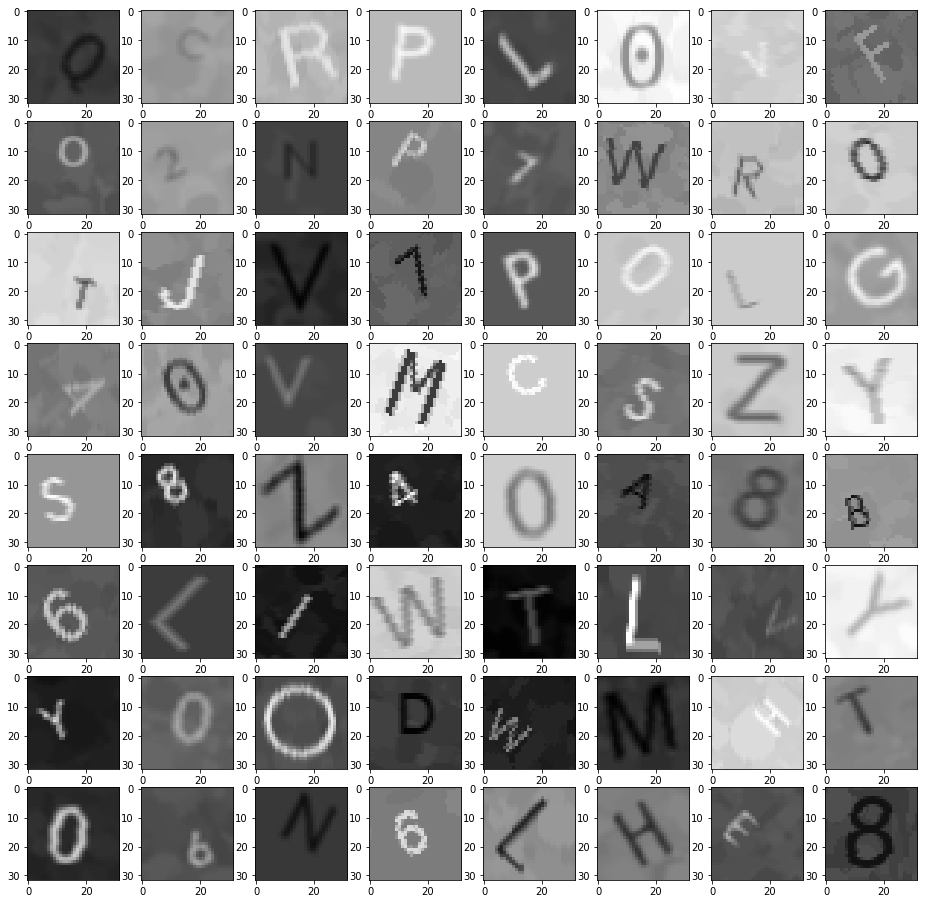

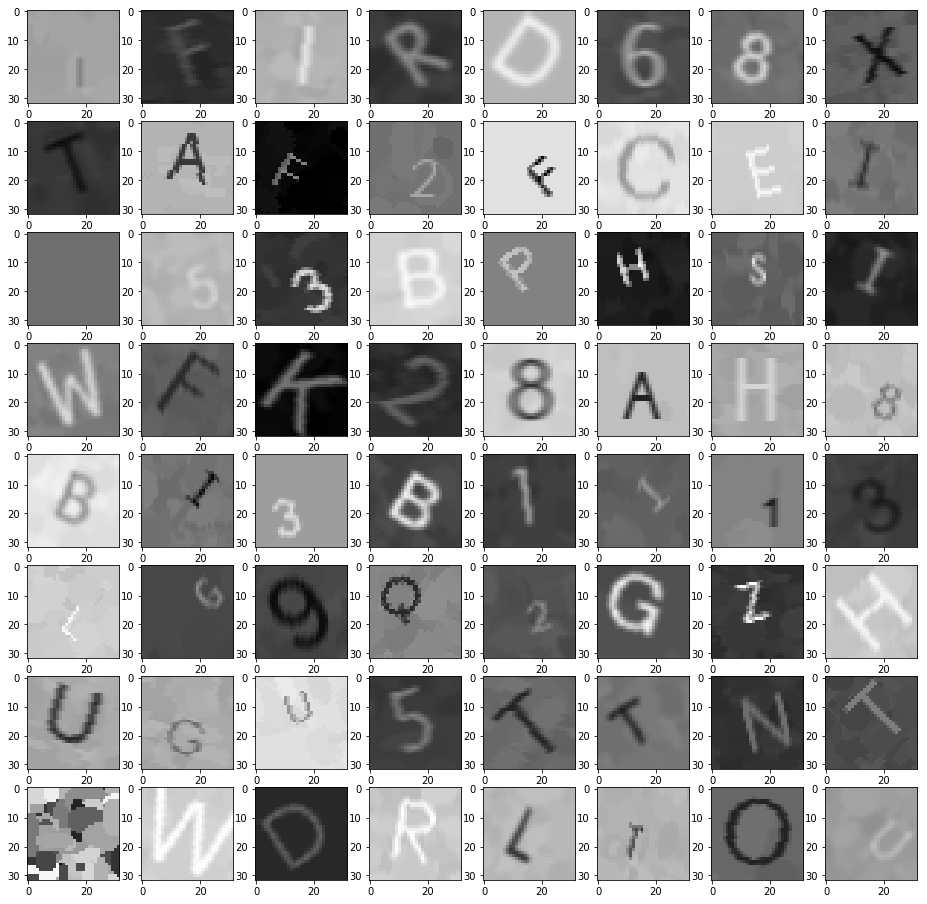

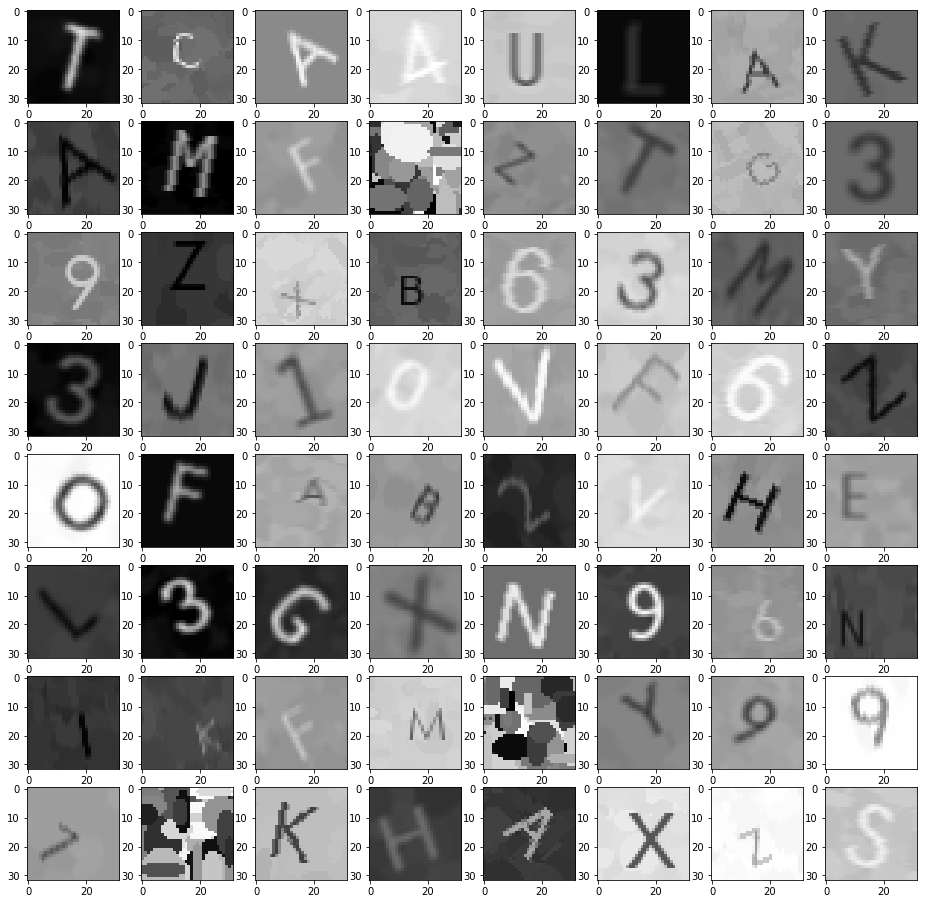

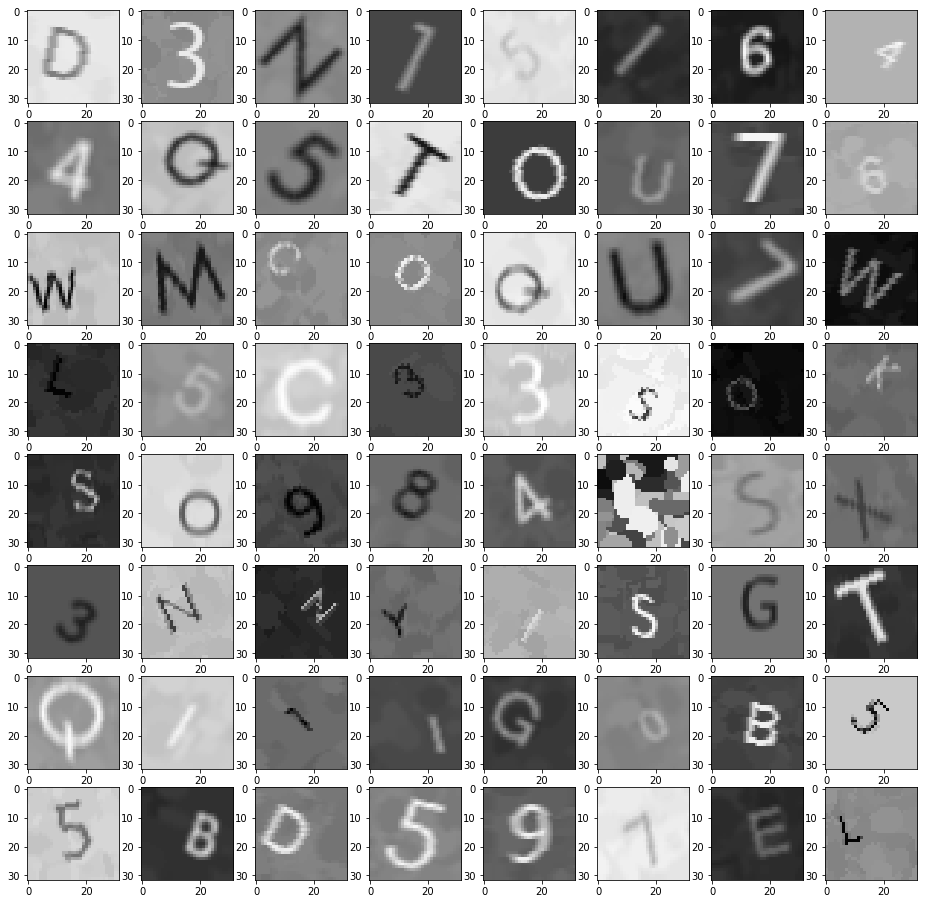

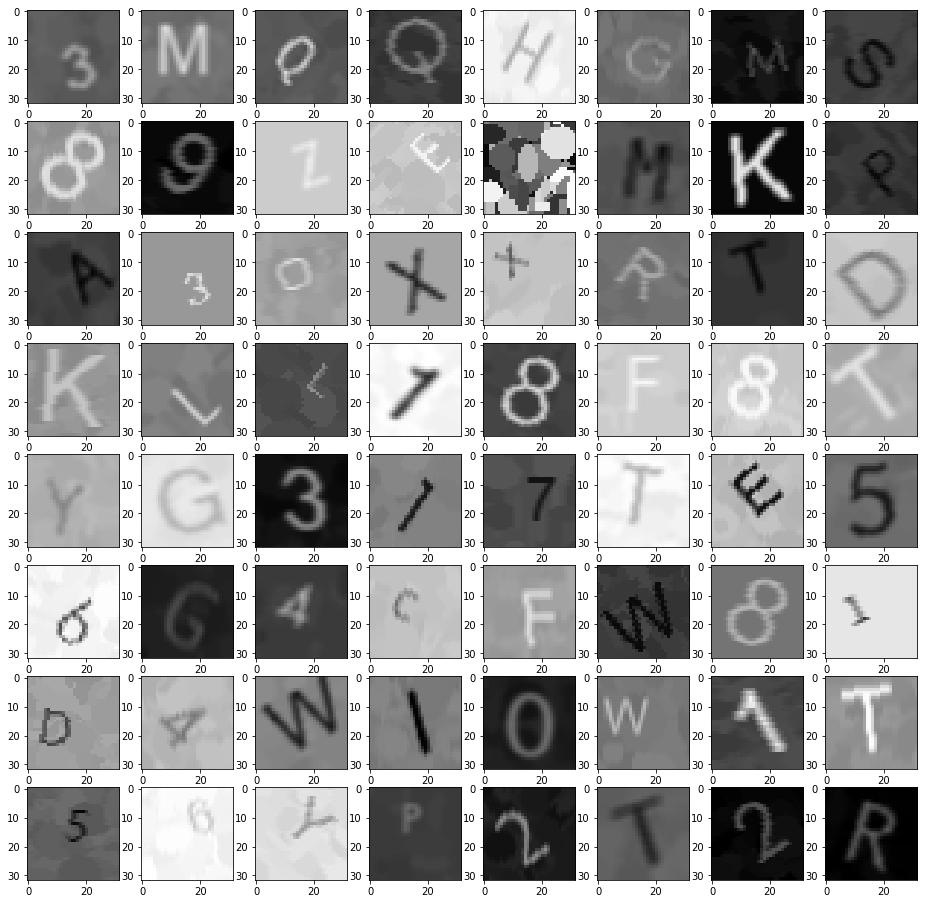

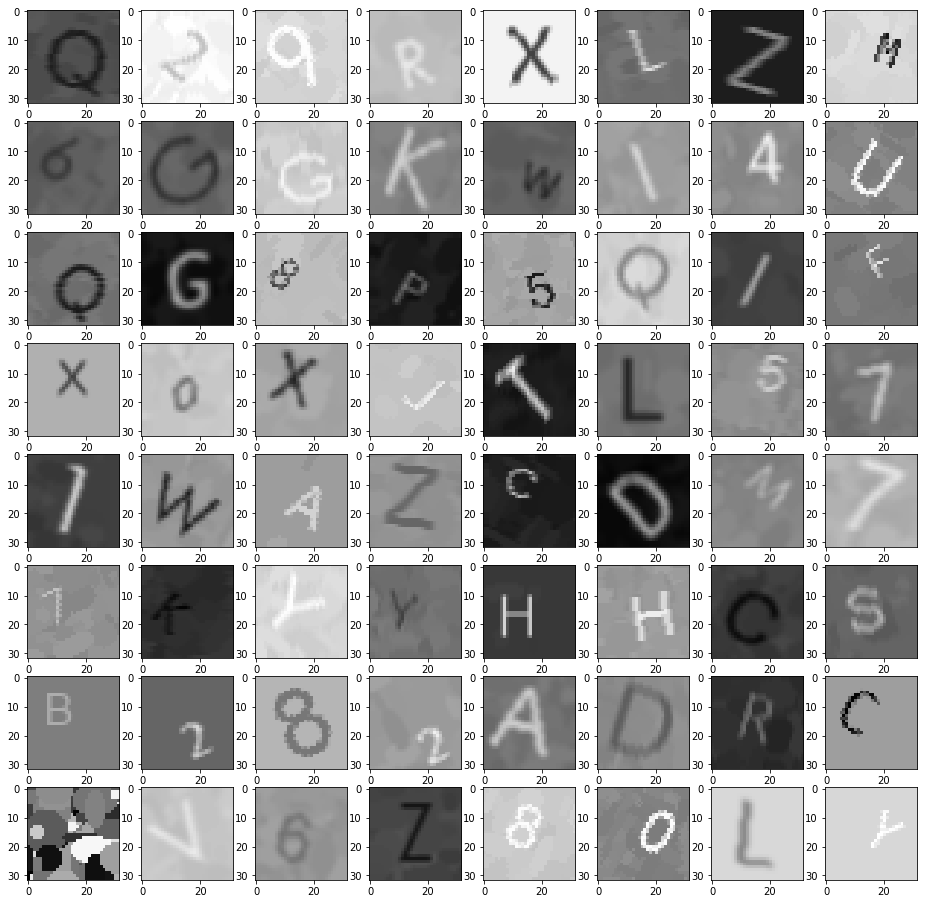

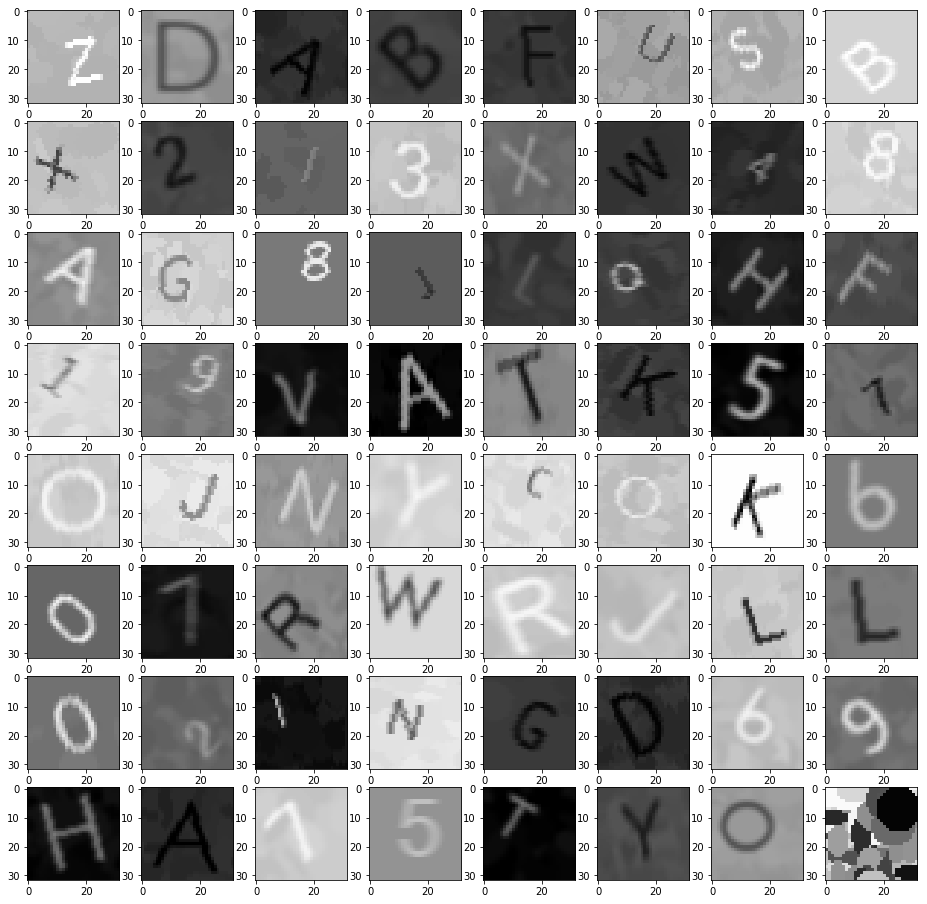

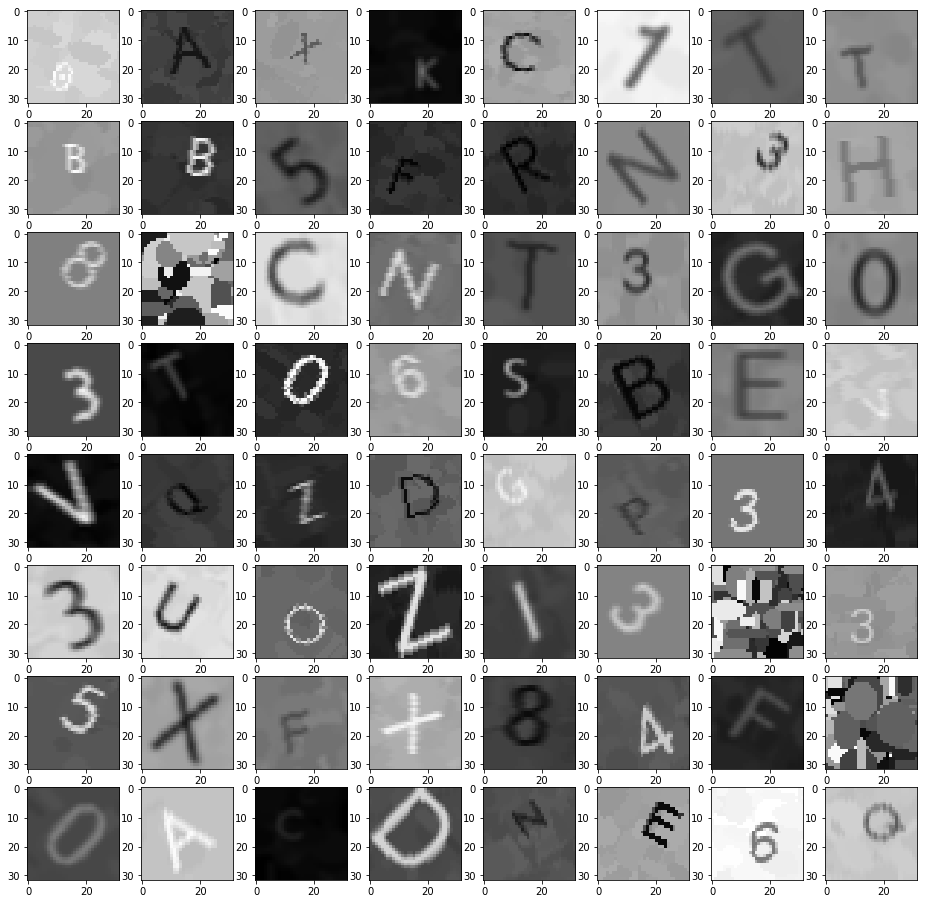

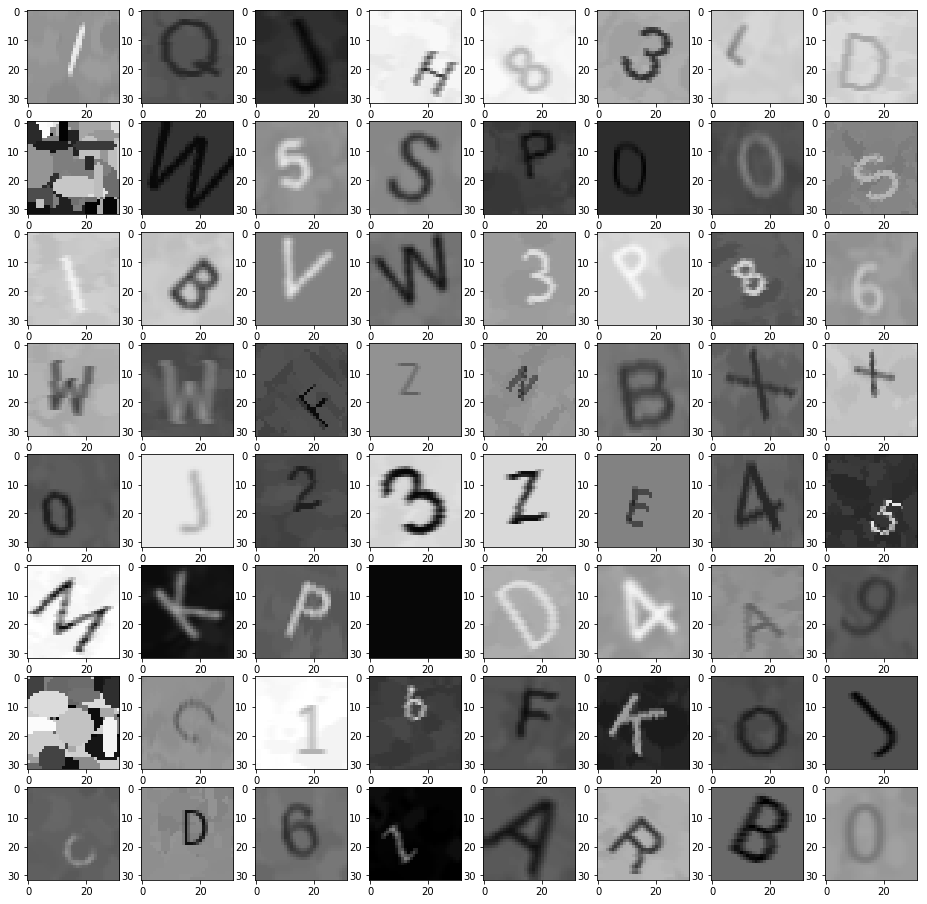

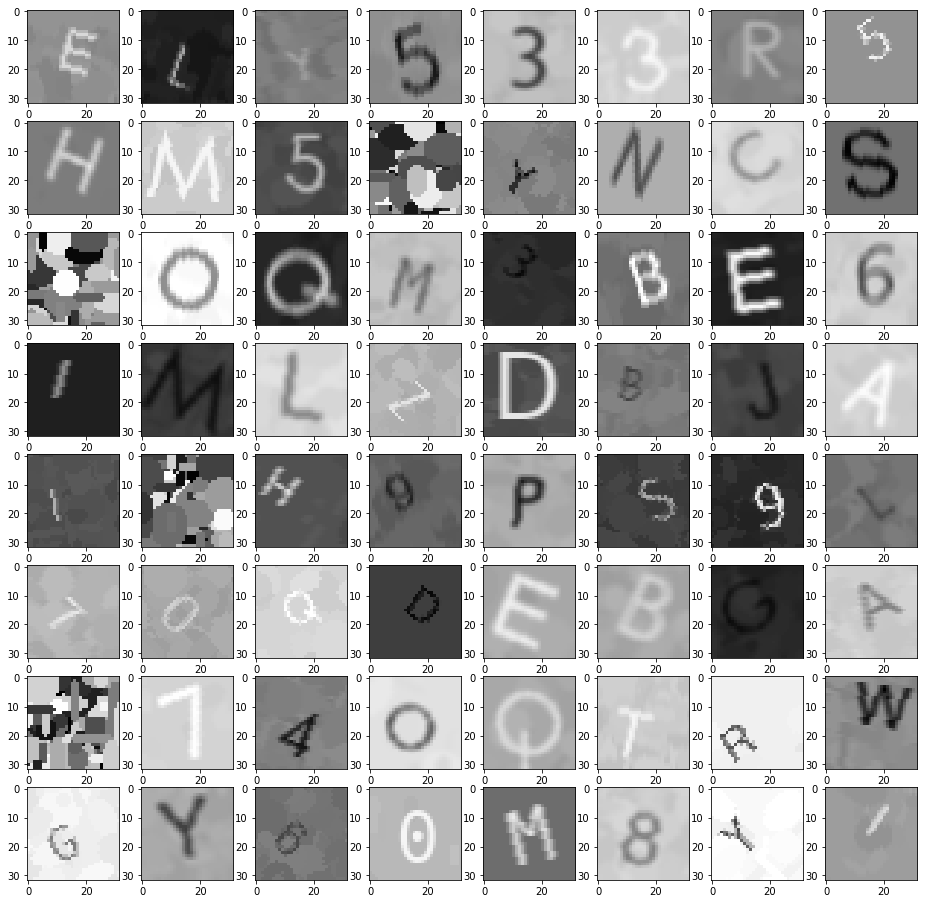

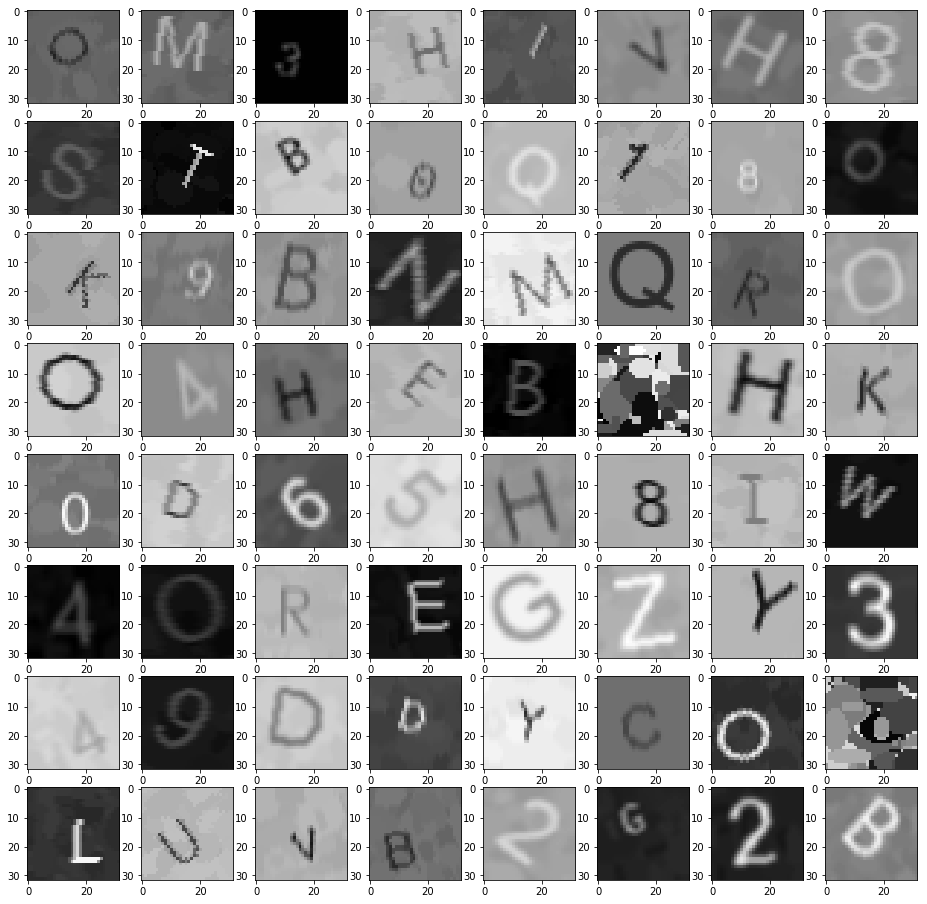

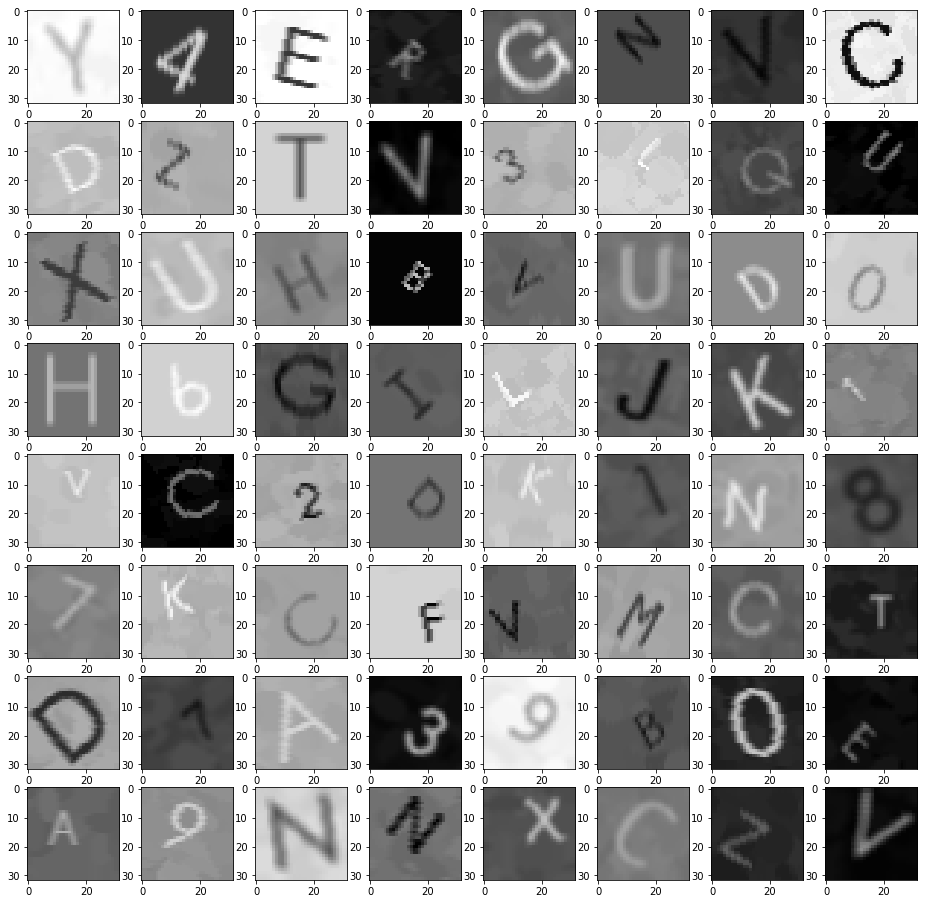

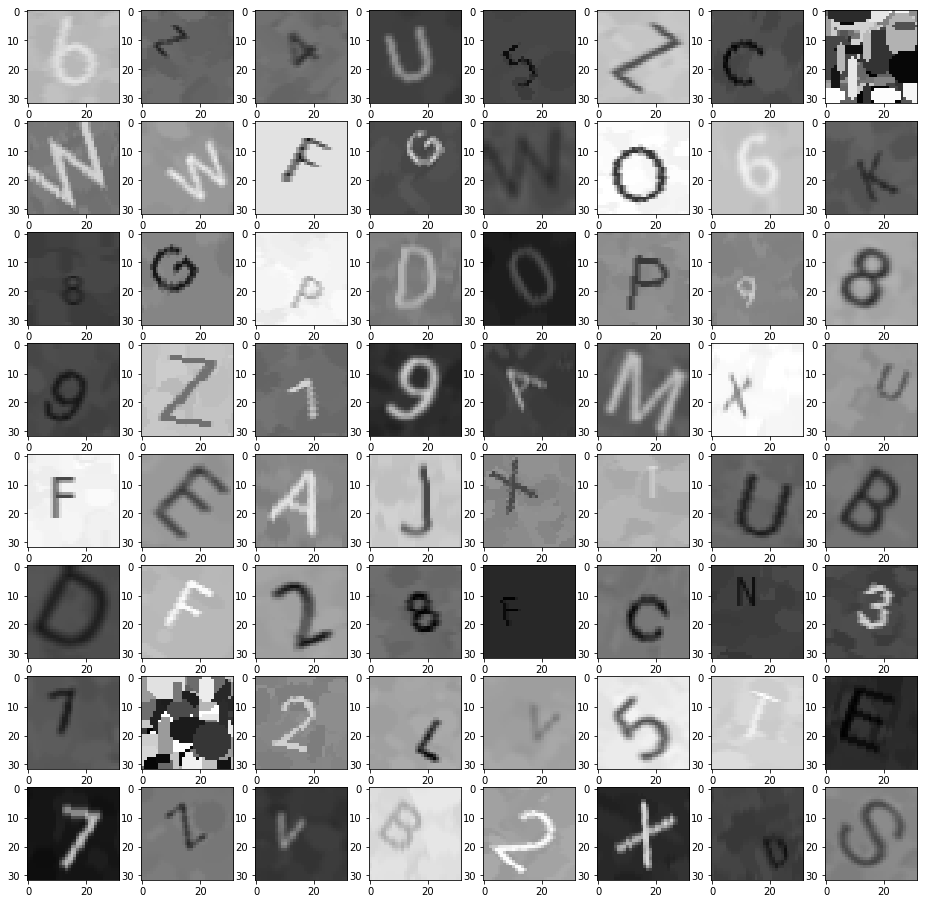

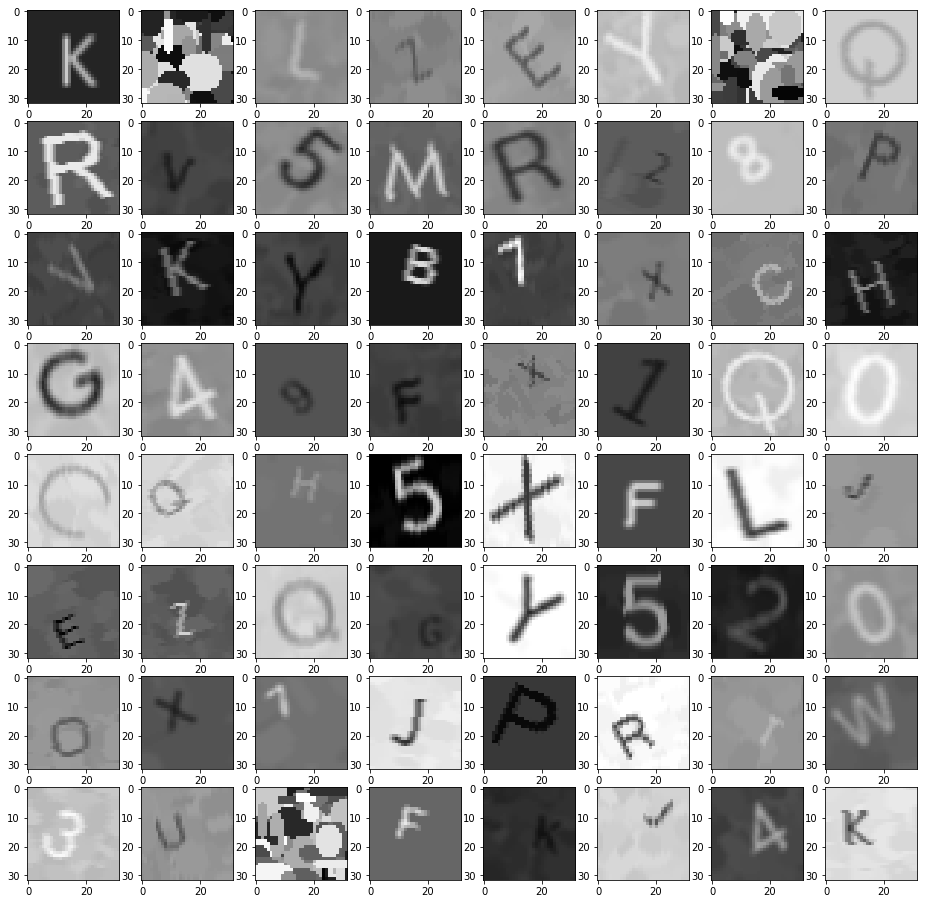

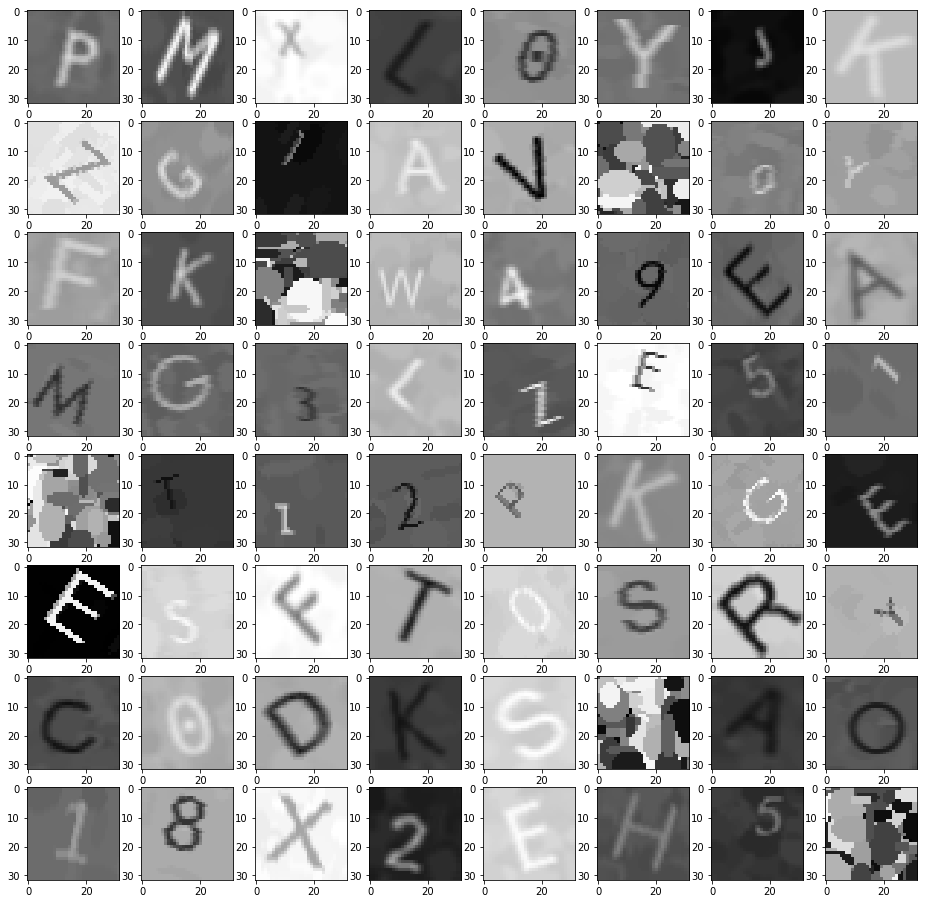

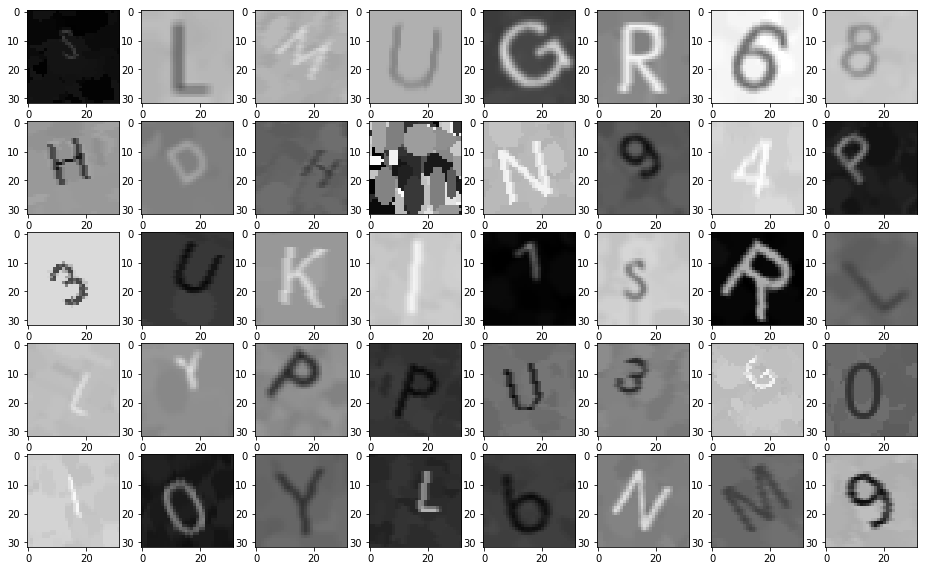

In [171]:
def plot_dataset(sample_count, one_dim_subplot_count=8):
    subplot_count = one_dim_subplot_count ** 2    
    for i in range(sample_count):
        if i % subplot_count == 0:
            plt.figure(figsize=(16, 16))
        plot_num = (i + 1) % subplot_count
        if plot_num == 0:
            plot_num = subplot_count
        plt.subplot(one_dim_subplot_count, one_dim_subplot_count, plot_num) 
        plt.imshow(ImageGenerator(40, True, True).generate_image(), cmap='gray', vmin=0, vmax=255)
        if (i + 1) % subplot_count == 0:
            plt.show()
            
plot_dataset(1000)

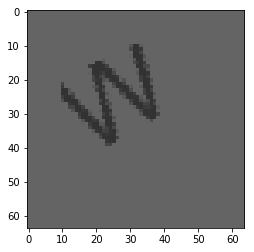

In [5]:
org_image = Image.new('L', (32 * 2, 32 * 2), 100)
pil_image = Image.new('L', (32 * 2, 32 * 2), 100)
font = FontProxy().generate_font('Arial', 32)
offset = font.getoffset('TEXT')
text_size = font.getsize("W")
ImageDraw.Draw(pil_image).text(((64 - text_size[0] - offset[0]) / 2, (64 - text_size[1] - offset[1]) / 2), "W", 50, font)  
pil_image = pil_image.rotate(30)
pil_image = pil_image.crop((16, 16, 48, 48))
org_image.paste(pil_image, (10, 10))
plt.imshow(np.array(org_image), cmap='gray', vmin=0, vmax=255)

